In [3]:
# All code in this assignment was generated by ChatGPT. However,
# The general design of each model in this file was done manually by us students,
# and the code was made with principles from lectures in mind.
# We used AI as a tool rather than a decision maker.
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("go_emotions")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [4]:
import pandas as pd
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])
labels = dataset["train"].features["labels"].feature.names

ekman_map = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": ["joy", "amusement", "approval", "excitement", "gratitude",
            "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "neutral": ["neutral"]
}

goemotion_to_ekman = {}

for group, emotion_list in ekman_map.items():
    for emotion in emotion_list:
        goemotion_to_ekman[emotion] = group

def convert_to_ekman(row):
    ids = row["labels"]
    if len(ids) == 0:
        return "neutral"

    first_id = ids[0]
    emotion_name = labels[first_id]
    return goemotion_to_ekman[emotion_name]


df_train["ekman"] = df_train.apply(convert_to_ekman, axis=1)
df_val["ekman"] = df_val.apply(convert_to_ekman, axis=1)
df_test["ekman"] = df_test.apply(convert_to_ekman, axis=1)

ekman_classes = sorted(df_train["ekman"].unique())

ekman_to_id = {emotion: idx for idx, emotion in enumerate(ekman_classes)}

df_train["label"] = df_train["ekman"].map(ekman_to_id)
df_val["label"] = df_val["ekman"].map(ekman_to_id)
df_test["label"] = df_test["ekman"].map(ekman_to_id)



In [5]:
print("All text:", df_train["text"])

All text: 0        My favourite food is anything I didn't have to...
1        Now if he does off himself, everyone will thin...
2                           WHY THE FUCK IS BAYLESS ISOING
3                              To make her feel threatened
4                                   Dirty Southern Wankers
                               ...                        
43405    Added you mate well I’ve just got the bow and ...
43406    Always thought that was funny but is it a refe...
43407    What are you talking about? Anything bad that ...
43408              More like a baptism, with sexy results!
43409                                      Enjoy the ride!
Name: text, Length: 43410, dtype: object


In [6]:
df_train.head()

,text,labels,id,ekman,label
0,My favourite food is anything I didn't have to...,[27],eebbqej,neutral,4
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,neutral,4
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,anger,0
3,To make her feel threatened,[14],ed7ypvh,fear,2
4,Dirty Southern Wankers,[3],ed0bdzj,anger,0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [ ]:
# Tokenization
from collections import Counter

import re

def tokenize(text):
    text = text.lower()

    # separate punctuation from words
    text = re.sub(r"([.,!?;()])", r" \1 ", text)

    # handle contractions
    text = re.sub(r"n['’]t", " not", text)
    text = re.sub(r"['’]re", " are", text)
    text = re.sub(r"['’]s", " is", text)
    text = re.sub(r"['’]m", " am", text)
    text = re.sub(r"['’]ll", " will", text)
    text = re.sub(r"['’]ve", " have", text)
    text = re.sub(r"['’]d", " would", text)

    # keep only letters, numbers, and basic punctuation
    text = re.sub(r"[^a-z0-9.,!?;() ]+", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    # split into tokens
    tokens = text.split(" ")

    return tokens


counter = Counter()

for text in df_train["text"]:
    counter.update(tokenize(text))

pad_token = "<pad>"
unk_token = "<unk>"

itos = []       # index to string
stoi = {}       # string to index
# add special tokens first
itos.append(pad_token)
itos.append(unk_token)

stoi[pad_token] = 0
stoi[unk_token] = 1

index = 2

for word, count in counter.most_common():
    itos.append(word)
    stoi[word] = index
    index += 1

In [ ]:
# Encoding Step

import torch

MAX_LEN = 30

def encode(text):
    tokens = tokenize(text)
    ids = [stoi.get(t, stoi["<unk>"]) for t in tokens]

    # truncate
    if len(ids) > MAX_LEN:
        ids = ids[:MAX_LEN]

    # pad
    if len(ids) < MAX_LEN:
        ids = ids + [stoi["<pad>"]] * (MAX_LEN - len(ids))

    return torch.tensor(ids, dtype=torch.long)

GLOVE:::

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip


--2025-12-13 09:20:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-12-13 09:20:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-12-13 09:20:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_path = "glove.6B.100d.txt"

glove = {}

with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = torch.tensor([float(x) for x in values[1:]], dtype=torch.float)
        glove[word] = vector


In [ ]:
embed_dim = 100

embedding_matrix = torch.zeros((len(itos), embed_dim))


In [ ]:
for idx, word in enumerate(itos):
    if word in glove:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = torch.randn(embed_dim) * 0.1


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, df):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode(self.texts[idx])
        y = int(self.labels[idx])
        return x, y

def collate_fn(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return padded, labels

In [ ]:
train_loader = DataLoader(EmotionDataset(df_train), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(EmotionDataset(df_val), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(EmotionDataset(df_test), batch_size=32, collate_fn=collate_fn)


In [ ]:
class CNNEmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, dropout_rate, embedding_matrix):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(embedding_matrix)

        self.conv3 = nn.Conv1d(embed_dim, 128, kernel_size=3)
        self.conv4 = nn.Conv1d(embed_dim, 128, kernel_size=4)
        self.conv5 = nn.Conv1d(embed_dim, 128, kernel_size=5)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(dropout_rate)

        self.fc = nn.Linear(128  * 3, num_classes)

    def forward(self, x):
        # x shape: batch, seq_len
        embedded = self.embedding(x)

        embedded = embedded.permute(0, 2, 1)

        c3 = self.relu(self.conv3(embedded))
        c4 = self.relu(self.conv4(embedded))
        c5 = self.relu(self.conv5(embedded))

        # max pooling
        p3 = torch.max(c3, dim=2).values
        p4 = torch.max(c4, dim=2).values
        p5 = torch.max(c5, dim=2).values

        combined = torch.cat([p3, p4, p5], dim=1)

        combined = self.dropout(combined)

        output = self.fc(combined)

        return output


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

model = CNNEmotionClassifier(
    vocab_size=len(itos),
    embed_dim=100,
    num_classes=df_train["label"].nunique(),
    dropout_rate=0.3,
    embedding_matrix=embedding_matrix
)

model = model.to(device)



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
best_val_loss = float("inf")

# The below was used for class balancing, but was not in final code due to performance (mentioned in paper)

# # Applying class weights
# class_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(df_train["label"]),
#     y=df_train["label"]
# )

# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
# Training loop

def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        predictions = model(x)
        loss = loss_fn(predictions, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)
    return average_train_loss

def validate_one_epoch(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            predictions = model(x)
            loss = loss_fn(predictions, y)

            total_loss += loss.item()

    average_val_loss = total_loss / len(val_loader)
    return average_val_loss




In [ ]:
num_epochs = 10
patience = 2
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print("Epoch", epoch + 1)

    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss = validate_one_epoch(model, val_loader, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print("Train loss:", train_loss)
    print("Validation loss:", val_loss)

    if val_loss < best_val_loss:
        print("Validation improved, saving model")
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_cnn.pt")
    else:
        patience_counter += 1
        print("No improvement. Patience =", patience_counter)

        if patience_counter >= patience:
            print("Early stopping activated")
            break

model.load_state_dict(torch.load("best_cnn.pt"))
model = model.to(device)


Epoch 1
Train loss: 1.1570361137126595
Validation loss: 1.0155080683091107
Validation improved, saving model
Epoch 2
Train loss: 0.9407598472686928
Validation loss: 0.9438701184356914
Validation improved, saving model
Epoch 3
Train loss: 0.8427110058073621
Validation loss: 0.9424560224308687
Validation improved, saving model
Epoch 4
Train loss: 0.7529984171898293
Validation loss: 0.9626293859061072
No improvement. Patience = 1
Epoch 5
Train loss: 0.657355780055089
Validation loss: 1.0032447601065917
No improvement. Patience = 2
Early stopping activated


In [ ]:
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_true.extend(y.cpu().tolist())

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# convert integer predictions to emotion names
id_to_ekman = {v: k for k, v in ekman_to_id.items()}

true_names = [id_to_ekman[i] for i in all_true]
pred_names = [id_to_ekman[i] for i in all_preds]

# metrics
accuracy = accuracy_score(true_names, pred_names)

precision, recall, f1, _ = precision_recall_fscore_support(
    true_names,
    pred_names,
    average="macro"
)

print("Accuracy:", accuracy)
print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1:", f1)
print()
print("Classification Report:")
print(classification_report(true_names, pred_names))


Accuracy: 0.6467661691542289
Macro Precision: 0.6066874625404741
Macro Recall: 0.5333822051739548
Macro F1: 0.5629435625602714

Classification Report:
              precision    recall  f1-score   support

       anger       0.49      0.45      0.47       703
     disgust       0.52      0.39      0.45        84
        fear       0.74      0.48      0.58        90
         joy       0.79      0.78      0.78      2054
     neutral       0.58      0.68      0.63      1606
     sadness       0.54      0.48      0.51       317
    surprise       0.58      0.47      0.52       573

    accuracy                           0.65      5427
   macro avg       0.61      0.53      0.56      5427
weighted avg       0.65      0.65      0.64      5427



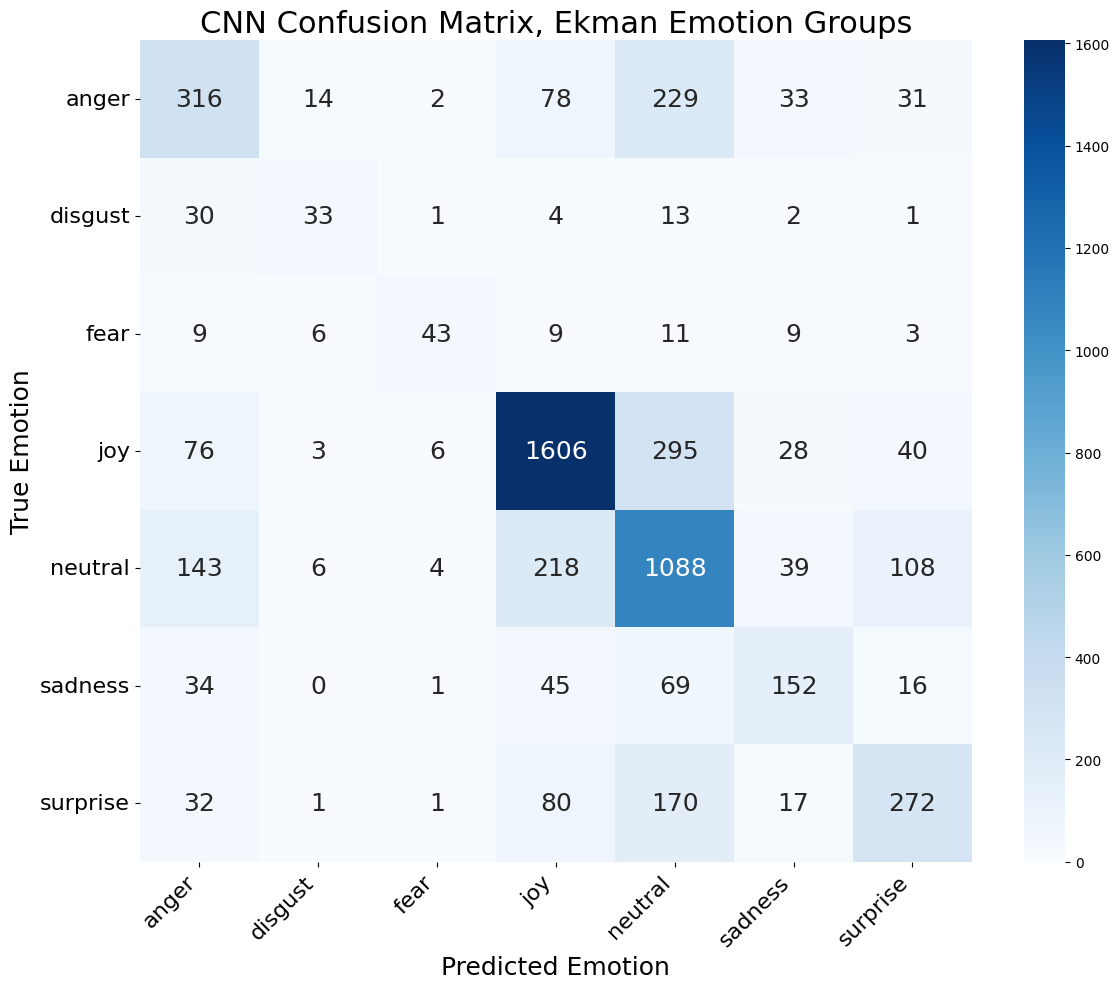

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#  sorted list
ekman_labels_sorted = sorted(ekman_to_id.keys())

#  confusion matrix
cm = confusion_matrix(true_names, pred_names, labels=ekman_labels_sorted)

# plot
plt.figure(figsize=(12, 10))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=ekman_labels_sorted,
    yticklabels=ekman_labels_sorted,
    annot_kws={"size": 18}   # increase number size here
)

plt.xlabel("Predicted Emotion", fontsize=18)
plt.ylabel("True Emotion", fontsize=18)
plt.title("CNN Confusion Matrix, Ekman Emotion Groups", fontsize=22)

plt.xticks(rotation=45, ha="right", fontsize=16)
plt.yticks(rotation=0, fontsize=16)

plt.tight_layout()
plt.show()


# The below was used to implement the manual gridsearch of the hyperparameter tuning. The parameters were extratced once and used.

In [ ]:
# search_space = {
#     "embed_dim": [128, 200],
#     "num_filters": [128, 256],
#     "dropout_rate": [0.3, 0.5],
#     "learning_rate": [0.001, 0.0005]
# }

# class CNNEmotionClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim, num_filters, num_classes, dropout_rate):
#         super().__init__()

#         # embedding layer
#         self.embedding = nn.Embedding(vocab_size, embed_dim)

#         # convolution layers with variable filter count
#         self.conv3 = nn.Conv1d(embed_dim, num_filters, kernel_size=3)
#         self.conv4 = nn.Conv1d(embed_dim, num_filters, kernel_size=4)
#         self.conv5 = nn.Conv1d(embed_dim, num_filters, kernel_size=5)

#         # activation
#         self.relu = nn.ReLU()

#         # dropout
#         self.dropout = nn.Dropout(dropout_rate)

#         # fully connected output layer
#         self.fc = nn.Linear(num_filters * 3, num_classes)

#     def forward(self, x):
#         embedded = self.embedding(x)

#         embedded = embedded.permute(0, 2, 1)

#         c3 = self.relu(self.conv3(embedded))
#         c4 = self.relu(self.conv4(embedded))
#         c5 = self.relu(self.conv5(embedded))

#         p3 = torch.max(c3, dim=2).values
#         p4 = torch.max(c4, dim=2).values
#         p5 = torch.max(c5, dim=2).values

#         combined = torch.cat([p3, p4, p5], dim=1)

#         combined = self.dropout(combined)

#         output = self.fc(combined)

#         return output



# def run_experiment(embed_dim, num_filters, dropout_rate, learning_rate):
#     model = CNNEmotionClassifier(
#         vocab_size=len(itos),
#         embed_dim=embed_dim,
#         num_filters=num_filters,
#         num_classes=df_train["label"].nunique(),
#         dropout_rate=dropout_rate
#     ).to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     loss_fn = nn.CrossEntropyLoss().to(device)

#     best_val = float("inf")
#     patience = 2
#     patience_counter = 0

#     for epoch in range(5):   # fewer epochs for search
#         train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
#         val_loss = validate_one_epoch(model, val_loader, loss_fn)

#         if val_loss < best_val:
#             best_val = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 break

#     return best_val


# import itertools

# keys = search_space.keys()
# values = search_space.values()

# best_config = None
# best_score = float("inf")

# for combo in itertools.product(*values):
#     params = dict(zip(keys, combo))

#     print("Testing:", params)

#     score = run_experiment(
#         embed_dim=params["embed_dim"],
#         num_filters=params["num_filters"],
#         dropout_rate=params["dropout_rate"],
#         learning_rate=params["learning_rate"]
#     )

#     print("Score:", score)

#     if score < best_score:
#         best_score = score
#         best_config = params

# print("Best configuration found:", best_config)


In [ ]:
# def predict(text):
#     tokens = tokenize(text)
#     ids = [stoi.get(t, stoi["<unk>"]) for t in tokens]
#     x = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)

#     with torch.no_grad():
#         logits = model(x)
#         pred = torch.argmax(logits, dim=1).item()

#     return id_to_ekman[pred]

# # Ask user for input
# user_input = input("Enter a sentence: ")
# while user_input.lower() != "exit":
#   emotion = predict(user_input)
#   print("Predicted emotion:", emotion)
#   user_input = input("Enter a sentence (type 'exit' to quit): ")
#   print()

In [ ]:
!pip install transformers


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoded = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=64,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "labels": torch.tensor(label)
        }


In [ ]:
train_loader = torch.utils.data.DataLoader(BERTDataset(df_train), batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(BERTDataset(df_val), batch_size=16)
test_loader = torch.utils.data.DataLoader(BERTDataset(df_test), batch_size=16)


In [ ]:
num_classes = df_train["label"].nunique()

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_classes
)

model = model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import get_scheduler
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [ ]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

    return total_loss / len(loader)


In [ ]:
best_val = float("inf")
patience = 2
patience_counter = 0

for epoch in range(5):
    print("Epoch", epoch + 1)

    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)

    print("Train loss:", train_loss)
    print("Val loss:", val_loss)

    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_bert.pt")
        print("Model improved, saving")
    else:
        patience_counter += 1
        print("No improvement, patience:", patience_counter)

        if patience_counter >= patience:
            print("Stopping early")
            break


Epoch 1
Train loss: 0.9233240981420877
Val loss: 0.8179880939862307
Model improved, saving
Epoch 2
Train loss: 0.7126627126015453
Val loss: 0.8471762238179936
No improvement, patience: 1
Epoch 3
Train loss: 0.5246893978412088
Val loss: 0.9467171305242706
No improvement, patience: 2
Stopping early


In [ ]:
model.load_state_dict(torch.load("best_bert.pt"))
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_true.extend(labels.cpu().tolist())


In [ ]:
from sklearn.metrics import classification_report

true_names = [id_to_ekman[i] for i in all_true]
pred_names = [id_to_ekman[i] for i in all_preds]

print(classification_report(true_names, pred_names))

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(
    true_names,
    pred_names,
    average="macro"
)

print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1:", f1)



              precision    recall  f1-score   support

       anger       0.60      0.53      0.56       703
     disgust       0.71      0.29      0.41        84
        fear       0.63      0.74      0.68        90
         joy       0.82      0.82      0.82      2054
     neutral       0.64      0.63      0.63      1606
     sadness       0.53      0.58      0.55       317
    surprise       0.56      0.65      0.60       573

    accuracy                           0.68      5427
   macro avg       0.64      0.61      0.61      5427
weighted avg       0.69      0.68      0.68      5427

Macro Precision: 0.6398334323097445
Macro Recall: 0.605743816630529
Macro F1: 0.6084693949546872


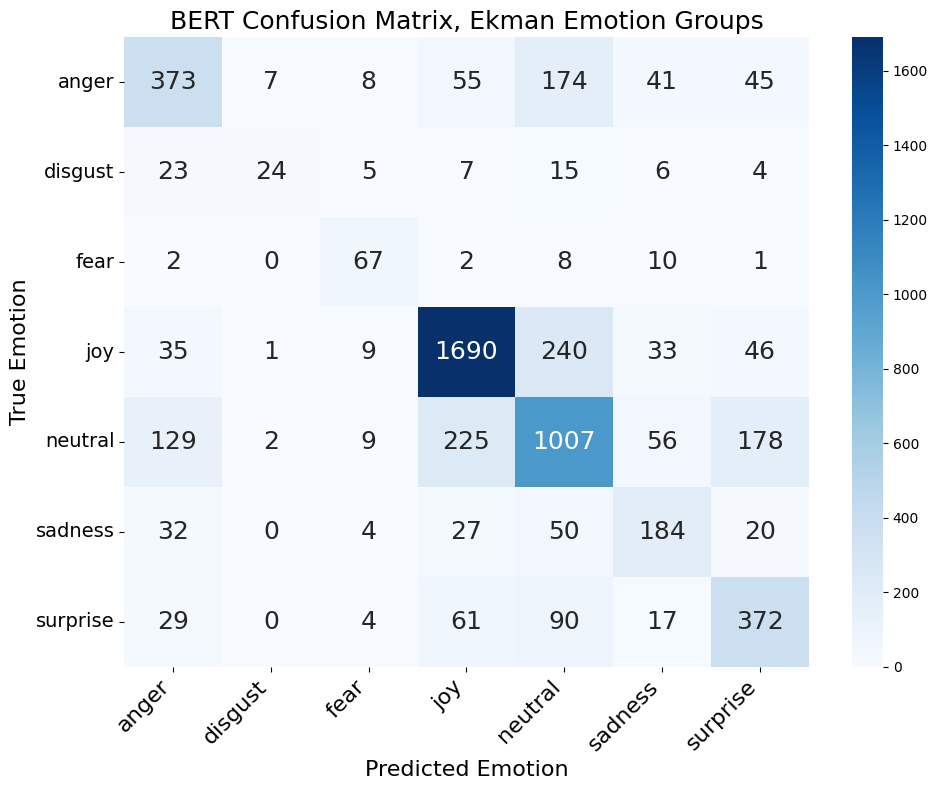

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_names, pred_names, labels=ekman_labels_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=ekman_labels_sorted,
    yticklabels=ekman_labels_sorted,
    annot_kws={"size": 18}
)

plt.xlabel("Predicted Emotion", fontsize=16)
plt.ylabel("True Emotion", fontsize=16)
plt.title("BERT Confusion Matrix, Ekman Emotion Groups", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=16)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
def predict_bert(text):
    encoded = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=64,
        return_tensors="pt"
    )

    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_id = torch.argmax(outputs.logits, dim=1).item()

    return id_to_ekman[pred_id]
while True:
    user_input = input("Enter a sentence (or 'exit'): ")
    if user_input.lower() == "exit":
        break
    print("Predicted emotion:", predict_bert(user_input))
    print()


Predicted emotion: joy

Predicted emotion: neutral

Predicted emotion: joy

Predicted emotion: anger

Predicted emotion: sadness

Predicted emotion: sadness



In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

df_train["svm_ekman"] = df_train["ekman"].apply(lambda x: [x])
df_val["svm_ekman"] = df_val["ekman"].apply(lambda x: [x])
df_test["svm_ekman"] = df_test["ekman"].apply(lambda x: [x])

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train["svm_ekman"])
y_val = mlb.transform(df_val["svm_ekman"])
y_test = mlb.transform(df_test["svm_ekman"])

X_train = df_train["text"]
X_val = df_val["text"]
X_test = df_test["text"]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

pipeline = Pipeline([
    ("features", FeatureUnion([
        ("word", TfidfVectorizer(
            analyzer="word",
            sublinear_tf=True
        )),
        ("char", TfidfVectorizer(
            analyzer="char",
            sublinear_tf=True
        ))
    ])),
    ("svm", OneVsRestClassifier(
        LinearSVC(class_weight="balanced")
    ))
])


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "features__word__ngram_range": [(1,2), (1,3)],
    "features__word__max_features": [20000, 40000],
    "features__char__ngram_range": [(3,4), (3,5)],
    "features__char__max_features": [10000, 20000],
    "svm__estimator__C": [0.1, 0.3]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=2,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters found")
print(grid.best_params_)
print("Best macro F1 during CV", grid.best_score_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters found
{'features__char__max_features': 20000, 'features__char__ngram_range': (3, 4), 'features__word__max_features': 40000, 'features__word__ngram_range': (1, 3), 'svm__estimator__C': 0.1}
Best macro F1 during CV 0.5297508958867521


Validation macro F1 0.5355660791448082
Test macro F1 0.554298268570765
Validation report
              precision    recall  f1-score   support

       anger       0.40      0.62      0.49       685
     disgust       0.29      0.45      0.35        74
        fear       0.48      0.61      0.54        85
         joy       0.82      0.75      0.78      2169
     neutral       0.52      0.74      0.61      1592
     sadness       0.39      0.64      0.48       299
    surprise       0.41      0.61      0.49       522

   micro avg       0.56      0.70      0.63      5426
   macro avg       0.47      0.63      0.54      5426
weighted avg       0.60      0.70      0.64      5426
 samples avg       0.59      0.70      0.63      5426

Test report
              precision    recall  f1-score   support

       anger       0.41      0.64      0.50       703
     disgust       0.36      0.49      0.42        84
        fear       0.53      0.68      0.60        90
         joy       0.80      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


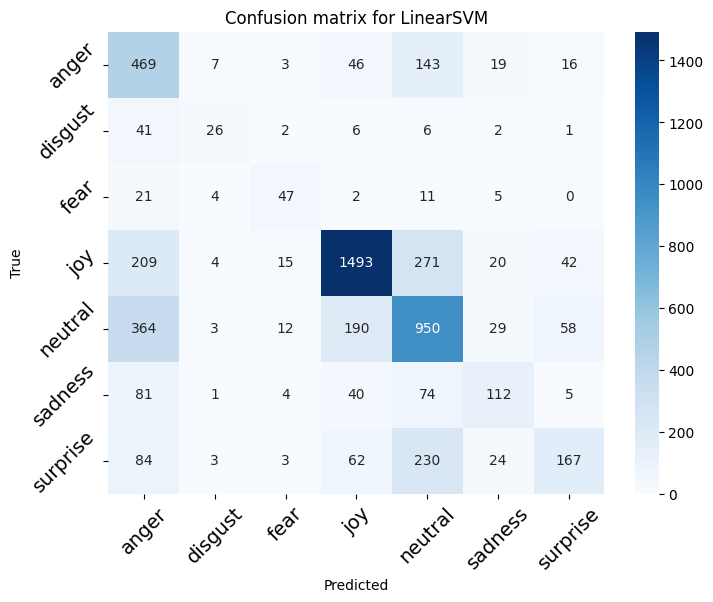

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

best_model = grid.best_estimator_

val_preds = best_model.predict(X_val)
test_preds = best_model.predict(X_test)

print("Validation macro F1", f1_score(y_val, val_preds, average="macro"))
print("Test macro F1", f1_score(y_test, test_preds, average="macro"))

print("Validation report")
print(classification_report(y_val, val_preds, target_names=mlb.classes_))

print("Test report")
print(classification_report(y_test, test_preds, target_names=mlb.classes_))

y_true_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(test_preds, axis=1)

cm = confusion_matrix(y_true_single, y_pred_single)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_,
            yticklabels=mlb.classes_)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for LinearSVM")
plt.show()

In [ ]:
def predict_emotion(text):
    pred = best_model.predict([text])[0]
    label = mlb.inverse_transform(pred.reshape(1, -1))[0]
    return label

def emotion_confidences(text):
    scores = best_model.decision_function([text])[0]
    label_scores = dict(zip(mlb.classes_, scores))
    return label_scores

def top3_emotions(text):
    scores = best_model.decision_function([text])[0]
    label_scores = list(zip(mlb.classes_, scores))
    label_scores.sort(key=lambda x: x[1], reverse=True)
    return label_scores[:3]

def print_prediction(text):
    print("Input text:", text)
    print("Predicted primary emotion:", predict_emotion(text))
    print("\nTop three predicted emotions:")
    for label, score in top3_emotions(text):
        print(f"{label}: {score:.4f}")

In [ ]:
print_prediction("I saw snow coming down and it made me feel very good")

Input text: I saw snow coming down and it made me feel very good
Predicted primary emotion: ('joy',)

Top three predicted emotions:
joy: 0.2821
fear: -0.1798
sadness: -0.3694
